# Non-Cartesian sampling: SPARKLING imaging

We explore the performance of SPARKLING (_Spreading projection Algorithm for Rapid K-space sampLING_) as non-Cartesian imaging technique. We do not actually provide the code of this algorithm but instead upload result files containing trajectories generated from the previous *radial in-out* initialization. For details, see the recently published paper: Lazarus et al, "SPARKLING: variable‐density k‐space filling curves for accelerated $T_2^*$ ‐weighted MRI", Magn Reson Med 2019; 81:3643:3661. 

- Author: Philippe Ciuciu (philippe.ciuciu@cea.fr)
- Date: 06/24/2022
- Update: 01/29/2024 (dependence on MRI-NUFFT for density compensation)
- Target: [IEEE EMBS-SPS Summer School](http://conferences.imt-atlantique.fr/ieeess/index.php?pid=1) on **Novel acquisition and image reconstruction strategies in accelerated Magnetic Resonance Imaging**

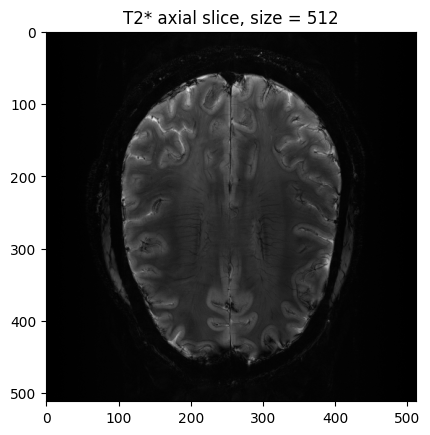

In [2]:
#DISPLAY T2* MR IMAGE 
%matplotlib inline

import numpy as np
import os.path as op
import os
import math ; import cmath
import matplotlib.pyplot as plt
import sys

from mri.operators import NonCartesianFFT
from mri.operators.utils import convert_locations_to_mask #, gridded_inverse_fourier_transform_nd
from pysap.data import get_sample_data
import mrinufft
from mrinufft.trajectories import display
from mrinufft import get_density


from skimage import data, img_as_float, io, filters
from modopt.math.metrics import ssim

mri_img = get_sample_data('2d-mri')
img_size = mri_img.shape[0]

plt.figure()
plt.title("T2* axial slice, size = {}".format(img_size))
if mri_img.ndim == 2:
    plt.imshow(mri_img, cmap=plt.cm.gray)
else:
    plt.imshow(mri_img)
plt.show()

15.0


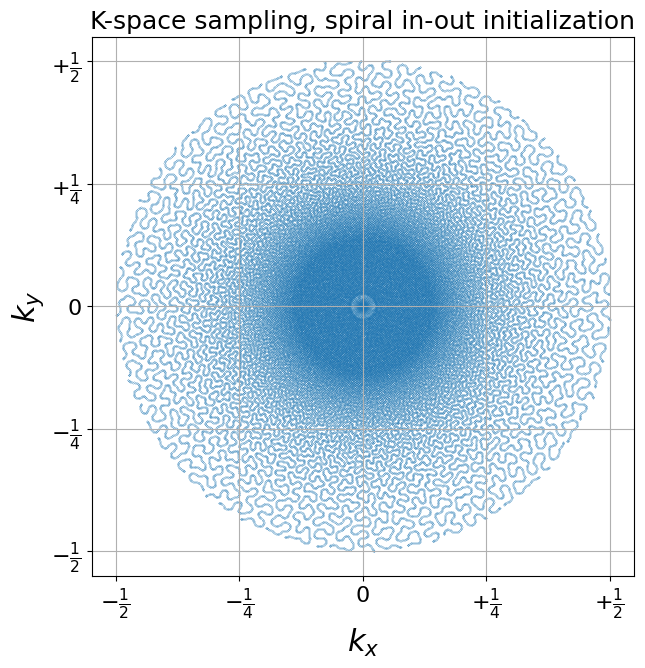

In [3]:
from scipy.io import loadmat

cwd = os.getcwd()
dirimg_2d = op.join(cwd,"..","data")

k_spark = loadmat(op.join(cwd, "..", "data","samples_SPARKLING_N512_nc34x3073_OS1.mat"))
rfactor = img_size/34
print(np.floor(rfactor))
k_spark_vec = k_spark['samples']

Kmax = np.amax(k_spark_vec)
#print(Kmax)

k_spark_vec = k_spark_vec*1/(2*np.pi*Kmax)

#save in npz format in the outdir directory
outdir = op.join(cwd,"..","output")
filename_traj = "sparkling_radial_N"  + str(img_size) + ".npz"
outfile = op.join(outdir, filename_traj)
np.savez(outfile, k_spark_vec)

k_spark = plt.figure(figsize=(7,7))
plt.scatter(k_spark_vec[:,0],k_spark_vec[:,1], marker = '.', s=0.1)
plt.grid()
#Figure layout

unit = 1/4
tick = np.arange(-0.5, 0.5 + unit, unit)

label = [r"$-\frac{1}{2}$", r"$-\frac{1}{4}$", r"$0$", r"$+\frac{1}{4}$",  r"$+\frac{1}{2}$"]

plt.xticks(tick/np.pi,labels = label, fontsize = 16) ; plt.yticks(tick/np.pi,labels = label, fontsize = 16)
plt.xlabel(r"$k_x$", fontsize = 22) ; plt.ylabel(r"$k_y$", fontsize = 22)
plt.title("K-space sampling, spiral in-out initialization",fontsize = 18)
plt.show()


In [14]:
data=convert_locations_to_mask(k_spark_vec, mri_img.shape)
#fourier_op = NonCartesianFFT(samples=k_spark_vec, shape=mri_img.shape,
#                             implementation='cpu')
#kspace_obs = fourier_op.op(mri_img.data)

NufftOperator = mrinufft.get_operator("finufft")
# For better image quality we use a density compensation
#density = "voronoi"
density = "cell_count"
#density = None
# And create the associated operator.
if density == None:
    nufft = NufftOperator(
        k_spark_vec.reshape(-1, 2), shape=mri_img.shape, density=None, n_coils=1
    )
elif density == "voronoi":
    voronoi_weights = get_density("voronoi", k_spark_vec.reshape(-1, 2))
    nufft = NufftOperator(
        k_spark_vec.reshape(-1, 2), shape=mri_img.shape, density=voronoi_weights, n_coils=1
    )
else:
    cell_count_weights = get_density("cell_count", k_spark_vec.reshape(-1, 2), shape=mri_img.shape, osf=2.0)
    nufft = NufftOperator(
        k_spark_vec.reshape(-1, 2), shape=mri_img.shape, density=cell_count_weights, n_coils=1, upsampfac=2.0
    )

kspace_obs = nufft.op(mri_img.data)  # Image -> Kspace
image2 = nufft.adj_op(kspace_obs)  # Kspace -> Image

/srv/conda/envs/notebook/lib/python3.10/site-packages/mrinufft/_utils.py:36: UserWarning: Samples will be rescaled to [-pi, pi), assuming they were in [-0.5, 0.5)
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.10/site-packages/mrinufft/operators/base.py:376: UserWarning: Data should be of dtype complex128 (is float32). Casting it for you.
  warnings.warn(


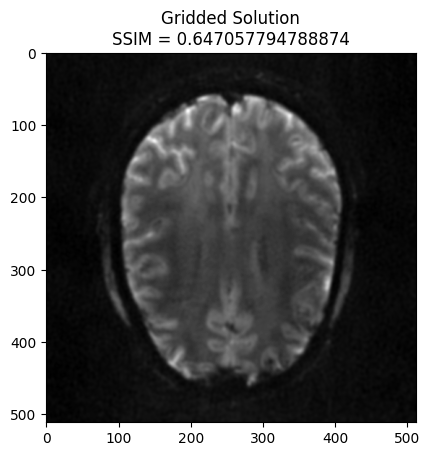

In [15]:
grid_space = np.linspace(-0.5, 0.5, num=mri_img.shape[0])
grid2D = np.meshgrid(grid_space, grid_space)
#grid_soln = gridded_inverse_fourier_trans#form_nd(k_spark_vec, kspace_obs,
#                                                 tuple(grid2D), 'linear')
#plt.imshow(np.abs(grid_soln), cmap='gray'
plt.imshow(np.abs(image2), cmap='gray')
# Calculate SSIM
base_ssim = ssim(image2, mri_img)
plt.title('Gridded Solution\nSSIM = ' + str(base_ssim))
plt.show()

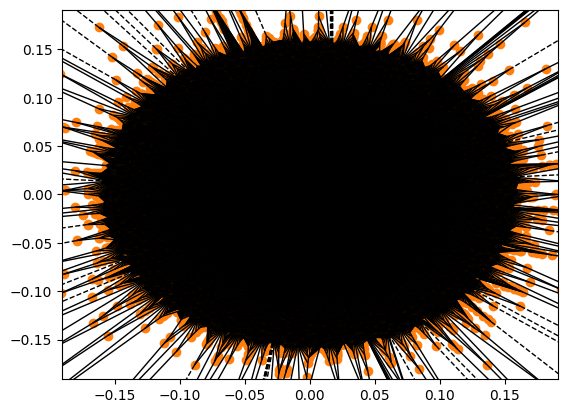

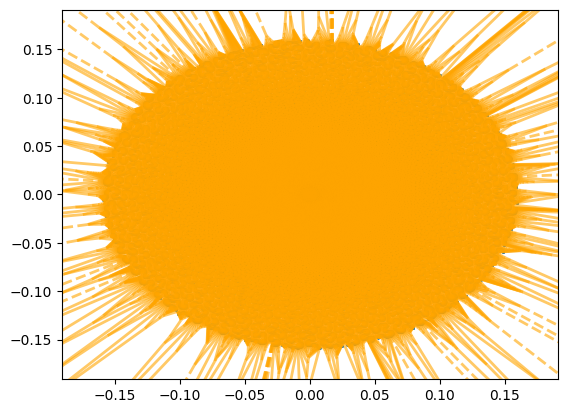

In [16]:
from scipy.spatial import Voronoi, voronoi_plot_2d

vor = Voronoi(k_spark_vec.reshape(-1, 2))
fig = voronoi_plot_2d(vor)

fig = voronoi_plot_2d(vor, show_vertices=False, line_colors='orange',
                      line_width=2, line_alpha=0.6, point_size=2)
plt.show()